In [1]:
# Initialize GPU
import pyclesperanto_prototype as cle
import beetlesafari as bs
import numpy as np
from skimage.io import imread

cle.select_device('RTX')

<Intel(R) UHD Graphics 620 on Platform: Intel(R) OpenCL HD Graphics (1 refs)>

## Loading image data and visualisation

c:\users\rober\miniconda3\lib\site-packages\pyopencl\__init__.py:252: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


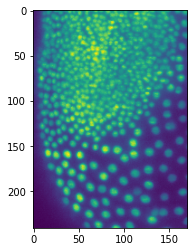

In [2]:
input_image = cle.push_zyx(imread('data/Lund_001000_head_lobe_crop.tif'))

cle.imshow(input_image)

## Spot detection + segmentation

c:\users\rober\miniconda3\lib\site-packages\pyopencl\__init__.py:252: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Number of cells 367.0
center spots:


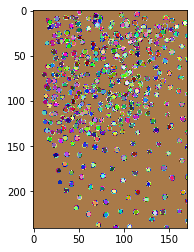

cells:


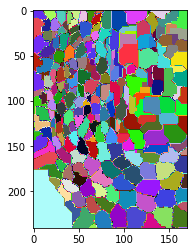

In [3]:
cells, spots = bs.segmentation(input_image)

print("Number of cells", cle.maximum_of_all_pixels(cells))

print("center spots:")
cle.imshow(cle.extend_labels_with_maximum_radius(spots, radius=2), labels=True)
print("cells:")
cle.imshow(cells, labels=True)

## Spot visualisation: 3D orthogonal planes
The coordinates of the spots are 3D. Thus, we can plot them in 2D as X/Y, Y/X and X/Z views.

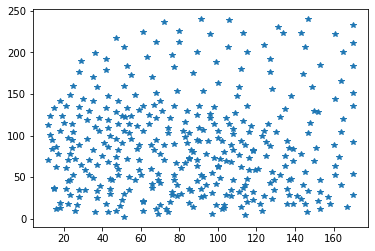

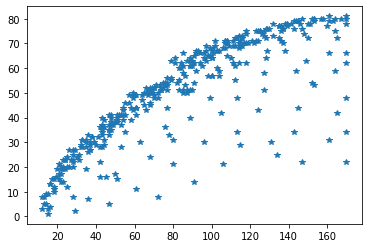

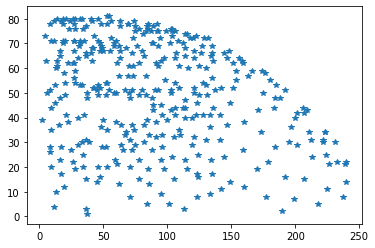

In [4]:
centroids = cle.labelled_spots_to_pointlist(spots)

np_centroids = cle.pull_zyx(centroids)
x_coords = np_centroids[0]
y_coords = np_centroids[1]
z_coords = np_centroids[2]

import matplotlib.pyplot as plt
plt.plot(x_coords, y_coords, "*")
plt.show()
plt.plot(x_coords, z_coords, "*")
plt.show()
plt.plot(y_coords, z_coords, "*")
plt.show()

## Measurements
### Distances between centroids

c:\users\rober\miniconda3\lib\site-packages\pyopencl\__init__.py:252: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


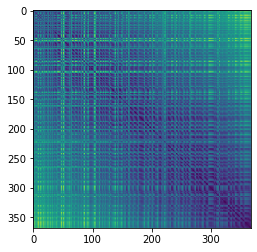

In [5]:
distance_matrix = cle.generate_distance_matrix(centroids, centroids)
cle.imshow(distance_matrix)

[ 0.         2.236068  12.4499     2.236068  11.224972   6.6332493
  8.485281   7.28011   15.394804  12.4499   ] ...


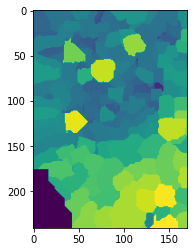

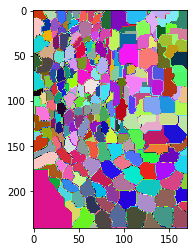

In [6]:
nearest_neighbor_distance = cle.average_distance_of_n_shortest_distances(distance_matrix, n=1)
print(nearest_neighbor_distance[0, 0:10], "...")

# make a parametric image
parametric_image = cle.replace_intensities(cells, nearest_neighbor_distance)
cle.imshow(parametric_image)
cle.imshow(cells, labels=True)

## Measure number of neighbors

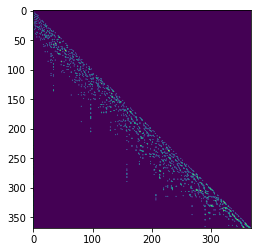

In [7]:
touch_matrix = cle.generate_touch_matrix(cells)
cle.imshow(touch_matrix)

[339.   3.   4.   7.   5.   4.   8.   7.   4.   6.] ...
[0. 3. 4. 7. 5. 4. 8. 7. 4. 6.] ...


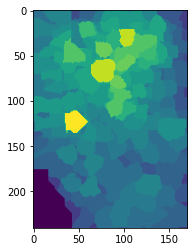

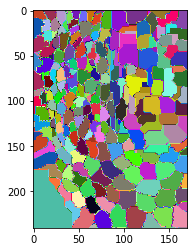

In [8]:
number_of_neighbors = cle.count_touching_neighbors(touch_matrix)
print(number_of_neighbors[0, 0:10], "...")

# set the number of neighbors of background (column 0) to 0 for visualisation purposes
cle.set_column(number_of_neighbors, 0, 0)
print(number_of_neighbors[0, 0:10], "...")

# make a parametric image
parametric_image = cle.replace_intensities(cells, number_of_neighbors)
cle.imshow(parametric_image)
cle.imshow(cells, labels=True)

## Clustering
We now take our measuremnts and cluster cells into two groups: Hopefully, embryo and serosa.

In [14]:
num_classes = 2

raw_data = [
    cle.pull_zyx(nearest_neighbor_distance)[0],
    cle.pull_zyx(number_of_neighbors)[0],
]

data = np.asarray(raw_data).T
print(data.shape)

(368, 2)


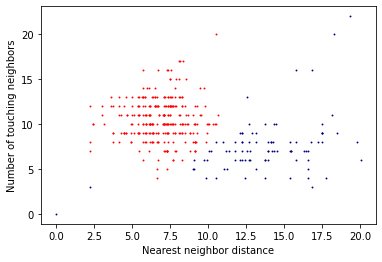

In [15]:
# inspired by https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm.html#sphx-glr-auto-examples-mixture-plot-gmm-py
colors = ['navy', 'red', 'darkgreen', 'gold', 'darkorange']

from sklearn import mixture

# fit a Gaussian Mixture Model with two components
clf = mixture.GaussianMixture(n_components=num_classes, covariance_type='full')
clf.fit(data)

gmm_prediction = clf.predict(data)

for i in range(clf.n_components):
    #splot = plt.subplot(2, 1, 1 + index)
    color = colors[i]
    plt.scatter(data[gmm_prediction == i, 0], data[gmm_prediction == i, 1], .8, color=color)

plt.xlabel("Nearest neighbor distance")
plt.ylabel("Number of touching neighbors")
plt.show()

[0. 1. 1. 2. 1. 2. 2. 2. 1. 1.] ...


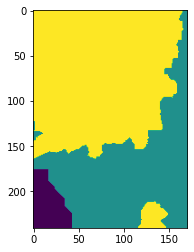

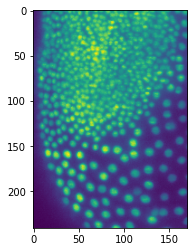

In [16]:
predicition_vector = cle.push_zyx(np.asarray([gmm_prediction]) + 1)

# set background to 0
cle.set_column(predicition_vector, 0, 0)
print(predicition_vector[0,0:10], "...")

# make a parametric image
parametric_image = cle.replace_intensities(cells, predicition_vector)
cle.imshow(parametric_image)
cle.imshow(input_image)

[0. 2. 1. 2. 2. 2. 2. 2. 1. 1.] ...


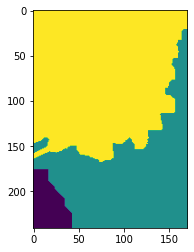

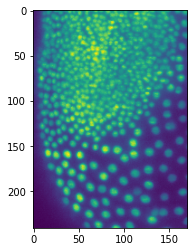

In [17]:
# vote for the most popular (mode) class in the neighborhood
predicition_vector = cle.mode_of_touching_neighbors(predicition_vector, touch_matrix)

# set background to 0
cle.set_column(predicition_vector, 0, 0)
print(predicition_vector[0,0:10], "...")

# make a parametric image
parametric_image = cle.replace_intensities(cells, predicition_vector)
cle.imshow(parametric_image)
cle.imshow(input_image)